# Proyecto Final - CAPSNETS

**Descripción de la Evidencia:**
El proyecto de aprendizaje profundo consiste en la solución del problema de clasificación de prendas de vestir utilizando el conjunto de datos Fashion MNIST. Éste código implementa un modelo de red neuronal CAPSNETS (_no visto en clase_) que resuelva el problema de clasificación.

A01285158 | Grace Aviance Silva Aróstegui

A00832881 | Christian Jaffé Alarcón Acosta

A01735864 | David Vázquez Moreno


In [1]:
# Librerías

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.utils import to_categorical
import os

from __future__ import division, print_function, unicode_literals



In [2]:
# Cargar los datos de fashion_mnist desde TF Keras

(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.

In [3]:
# Verificar que se han cargado los datos correctamente
X_train.shape

(60000, 28, 28, 1)

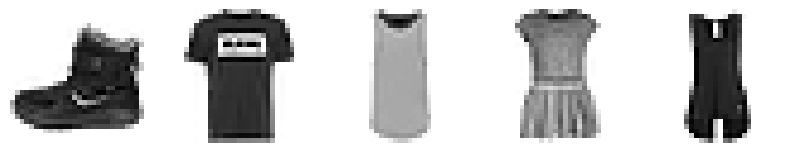

In [4]:
# Ver algunos ejemplos del dataset

n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = X_train[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [5]:
# Etiquetas del ejemplo
Y_train[:n_samples]

array([9, 0, 0, 3, 0], dtype=uint8)

### Input de las imagenes

Creamos un molde para las imagenes (28×28 pixeles, 1 color = grayscale).

In [6]:
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

### Capsulas primarias

In [7]:
# La primera capa estará compuesta por 32 mapas de 6×6 cápsulas cada uno, donde cada cápsula generará un vector de activación 8D:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

In [8]:
# Para calcular sus resultados, primero aplicamos dos capas convolucionales normales:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu, #Funcion de activación relu
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 filtros convolucionales
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu #Funcion de activación relu
}

In [9]:
# Cargar los paramatros a la red convolucional normal

conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)

<ipython-input-9-442f536f4182>:3: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.compat.v1.layers.conv2d(X, name="conv1", **conv1_params)
<ipython-input-9-442f536f4182>:4: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.compat.v1.layers.conv2d(conv1, name="conv2", **conv2_params)


**Nota**: puesto que usamos un tamaño de kernel de 9, la imagen se redujo en 9-1=8 píxeles después de cada capa convolucional (28×28 a 20×20, luego 20 × 20 a 12 × 12), y como usamos un paso de 2 en la segunda capa convolucional, el tamaño de la imagen se dividió por 2. Así es como terminamos con mapas de características de 6 × 6.

Con esto en mente, luego modificamos la salida para obtener un conjunto de vectores 8D que representan las salidas de las cápsulas primarias. La salida de conv2 es una matriz que contiene 32 × 8 = 256 mapas de características para cada instancia, donde cada mapa de características es 6 × 6. Entonces, la forma de esta salida es (tamaño de lote, 6, 6, 256). Queremos dividir el 256 en 32 vectores de 8 dimensiones cada uno. Podríamos hacer esto remodelando a (tamaño de lote, 6, 6, 32, 8). Sin embargo, dado que esta primera capa de cápsula estará completamente conectada a la siguiente capa de cápsula, podemos simplemente aplanar las grids de 6×6. Esto significa que al final serán (tamaño de lote, 6×6×32, 8).

In [10]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

In [11]:
# La función squash() aplastará todos los vectores en la matriz dada dentro de 0 a 1, a lo largo del eje dado (por defecto, el último eje).
# Es importante mencionar que no podemos usar una normalizacion la derivada de ∥s∥ no está definida cuando ∥s∥=0: si un vector es cero, los gradientes serán nan
# Este dato no lo conocíamos hasta revisar otras implementaciones del método

def squash(s, axis=-1, epsilon=1e-7, name=None):
    #with tf.name_scope(name, default_name="squash"):
    with tf.name_scope(name):
        #squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
        #                             keep_dims=True)
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [12]:
caps1_output = squash(caps1_raw, name="caps1_output")

## Cápsulas Digitales

### Calcular los vectores de salida previstos

In [13]:
caps2_n_caps = 10
caps2_n_dims = 16

In [14]:
init_sigma = 0.1

#W_init = tf.random_normal(
W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

In [15]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

In [16]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

In [17]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(None, 1152, 10, 16, 8) dtype=float32>

In [18]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

In [19]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 1152, 10, 16, 1) dtype=float32>

## Ruteo por aceptación



In [20]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

### Round 1

In [21]:
routing_weights = tf.nn.softmax(raw_weights, name="routing_weights")

In [22]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True,
                             name="weighted_sum")

In [23]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [24]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 10, 16, 1) dtype=float32>

### Round 2

In [25]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(None, 1152, 10, 16, 1) dtype=float32>

In [26]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(None, 1, 10, 16, 1) dtype=float32>

In [27]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

In [28]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

In [29]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

In [30]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keepdims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

In [31]:
caps2_output = caps2_output_round_2

### Loop dinámico o estático

In [32]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])


with tf.compat.v1.Session() as sess:
    print(sess.run(result))

[328350, 100]


In [33]:
sum([i**2 for i in range(1, 100 + 1)])

338350

### Probabilidades estimadas de cada clase (longitud)

In [34]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [35]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

In [36]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(None, 1, 1) dtype=int64>

In [37]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
y_pred

<tf.Tensor 'y_pred:0' shape=(None,) dtype=int64>

#### Labels

In [38]:
y = tf.compat.v1.placeholder(shape=[None], dtype=tf.int64, name="y")

#### Margin Loss

In [39]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [40]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

In [41]:
with tf.compat.v1.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [42]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 10, 16, 1) dtype=float32>

In [43]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

In [44]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

In [45]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

In [46]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

In [47]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

### Reconstruccion

#### Mask

In [48]:
mask_with_labels = tf.compat.v1.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

In [49]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

In [50]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(None, 10) dtype=float32>

In [51]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(None, 1, 10, 16, 1) dtype=float32>

In [52]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

In [53]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(None, 1, 10, 16, 1) dtype=float32>

In [54]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

#### Decoder

In [55]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [56]:
with tf.name_scope("decoder"):
    hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                                        name="hidden1")
    hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
                                        activation=tf.nn.relu,
                                        name="hidden2")
    decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,
                                               activation=tf.nn.sigmoid,
                                               name="decoder_output")

<ipython-input-56-2867c9c81853>:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden1 = tf.compat.v1.layers.dense(decoder_input, n_hidden1,
<ipython-input-56-2867c9c81853>:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden2 = tf.compat.v1.layers.dense(hidden1, n_hidden2,
<ipython-input-56-2867c9c81853>:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  decoder_output = tf.compat.v1.layers.dense(hidden2, n_output,


#### Reconstruction Loss

In [57]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

#### Final Loss

In [58]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

#### Accuracy

In [59]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

#### Training Operators


In [60]:
optimizer = tf.compat.v1.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

#### Init and Saver

In [61]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [62]:
len(X_train)

60000

In [63]:
X_train[0:0+50]

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.08, random_state=42)

In [65]:
len(X_train)

55200

In [66]:
len(X_val)

4800

In [67]:
X_val.shape

(4800, 28, 28, 1)

In [68]:
Y_val.shape

(4800,)

In [69]:
n_epochs = 12
batch_size = 18
restore_checkpoint = True

n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(X_val) // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.compat.v1.Session() as sess:
    if restore_checkpoint and tf.compat.v1.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        b0 = 0
        c0 = 0
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = X_train[b0:b0+batch_size], Y_train[b0:b0+batch_size]
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")
            b0+=batch_size

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = X_val[c0:c0+batch_size], Y_val[c0:c0+batch_size]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%) {}".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation, c0),
                  end=" " * 10)
            c0+=batch_size
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Epoch: 1  Val accuracy: 86.4870%  Loss: 0.097451 (improved)
Epoch: 2  Val accuracy: 87.8864%  Loss: 0.092859 (improved)
Epoch: 3  Val accuracy: 87.9073%  Loss: 0.090345 (improved)
Epoch: 4  Val accuracy: 88.4294%  Loss: 0.091095
Epoch: 5  Val accuracy: 88.3250%  Loss: 0.092442
Epoch: 6  Val accuracy: 88.0326%  Loss: 0.098845
Epoch: 7  Val accuracy: 88.0535%  Loss: 0.095083
Epoch: 8  Val accuracy: 88.0535%  Loss: 0.097473
Epoch: 9  Val accuracy: 87.9908%  Loss: 0.099547
Epoch: 10  Val accuracy: 88.1370%  Loss: 0.099193
Epoch: 11  Val accuracy: 87.9908%  Loss: 0.102342
Epoch: 12  Val accuracy: 87.5104%  Loss: 0.105535


#### Predictions

In [70]:
n_samples = 10

sample_images = X_test[:n_samples].reshape([-1, 28, 28, 1])

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

sample_images.shape

(10, 28, 28, 1)

In [71]:
decoder_output_value.reshape([-1, 28, 28]).shape

(10, 28, 28)

In [84]:
clothes_name = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
label_dict = dict(zip(list(range(len(clothes_name))), clothes_name, ))

In [85]:
label_dict[0]

'T-shirt/top'

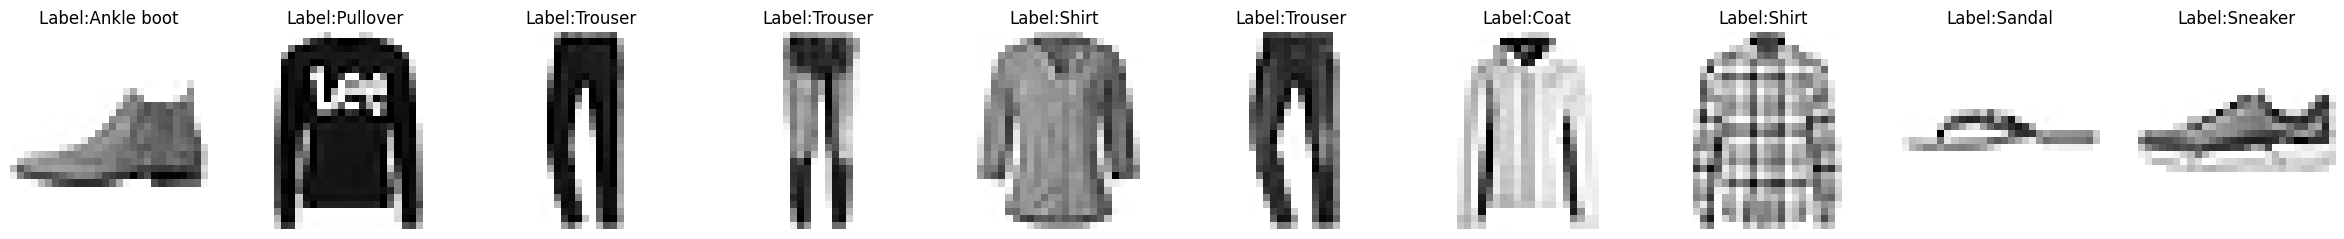

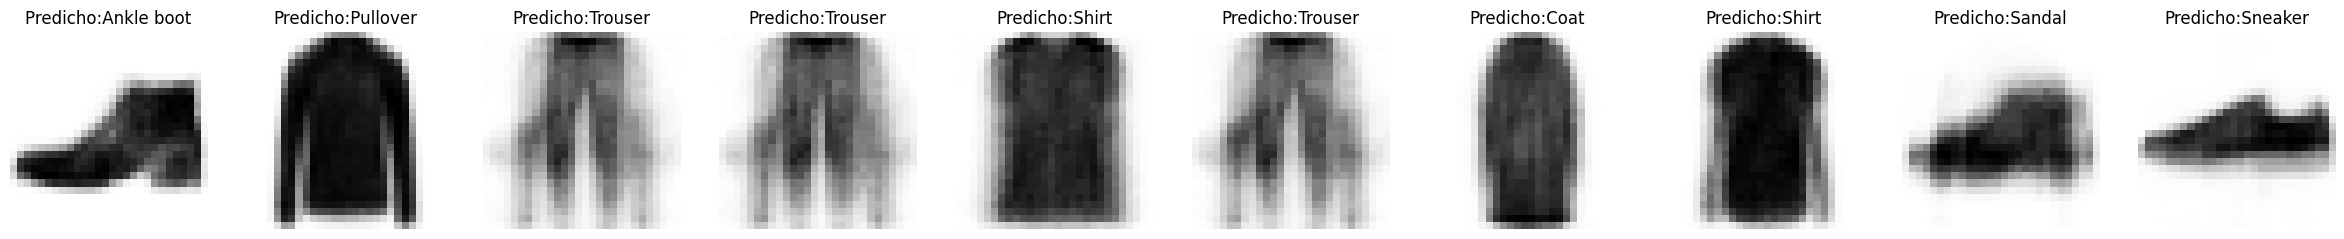

In [87]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 3, 5))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + label_dict[Y_test[index]])
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 3, 5))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicho:" + label_dict[y_pred_value[index]])
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")

plt.show()

#### Interpretacion de los vectores de output

In [73]:
caps2_output_value.shape

(10, 1, 10, 16, 1)

In [74]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

In [75]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

In [76]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

In [77]:
tweak_labels = np.tile(Y_test[:n_samples], caps2_n_dims * n_steps)

with tf.compat.v1.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

In [78]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Ajustando la dimensión de salida #0


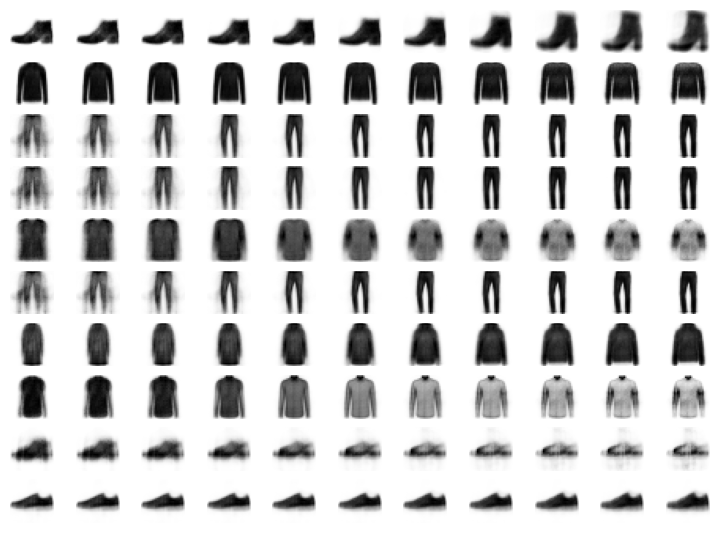

Ajustando la dimensión de salida #1


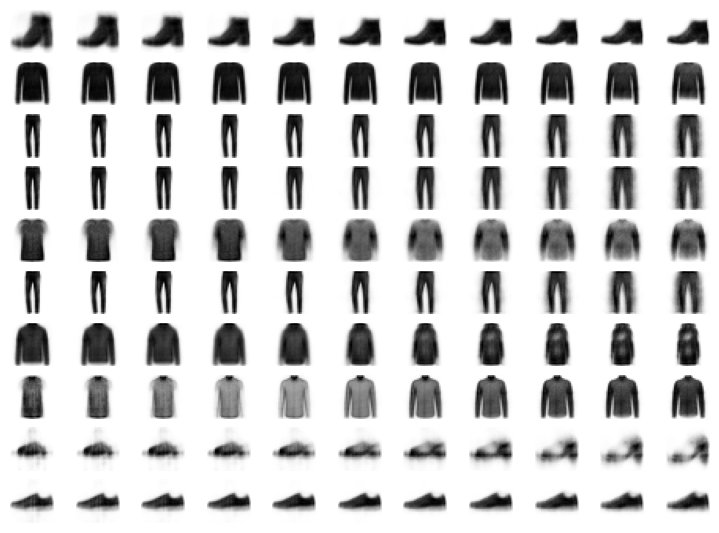

Ajustando la dimensión de salida #2


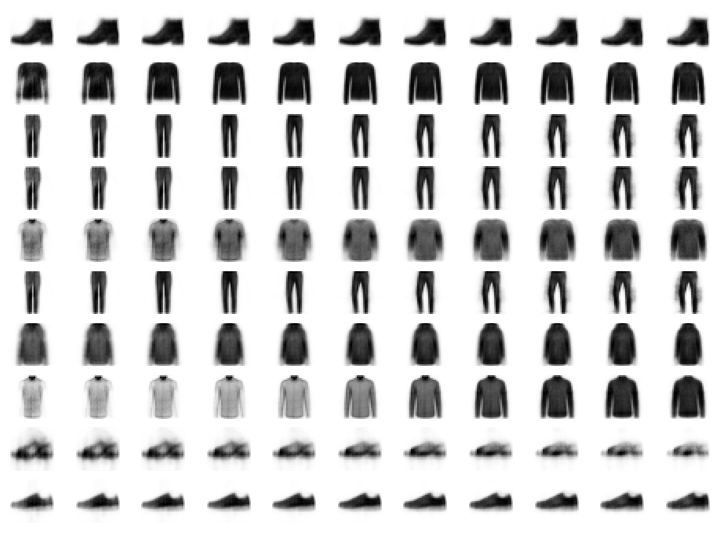

In [79]:
for dim in range(3):
    print("Ajustando la dimensión de salida #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()